## **STEP 1:** Loading the Dataset and the json file

In [1]:
import json
import os

## Path to the data directory
data_dir = '../../data/flower_data'

# Path to the JSON file
json_file_path = os.path.join(data_dir, 'cat_to_name.json')

In [2]:
json_file_path

'../../data/flower_data/cat_to_name.json'

In [3]:
with open(json_file_path, 'r') as f:
    cat_to_name = json.load(f)

In [4]:
num_classes = len(cat_to_name)

In [5]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

## **STEP-2:** Image transformation and dataset preparation using PyTorch's `ImageFolder`

**What we will do**
* Use `torchvision.transforms` to define how to process the images (resize, crop, normalize, etc.)
* Use `torchvision.datasets.ImageFolder` to load the images from folder structure
* Create PyTorch DataLoaders for train and val datasets
* Visualize a few sample images with their labels to verify preprocessing is correct

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


**Switching to dedicated GPU**

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


1. `RandomResizedCrop(224)`
* Randomly crops a region from the image and resizes it to 224x224 pixels.
* The crop size and aspect ratio are randomly selected within a range, so the model sees a variety of scales and parts of the image.
* This acts as data augmentation to help the model generalize better.

2. `RandomHorizontalFlip()`
* Randomly flips the image horizontally (left to right) with a 50% chance.
* Another form of data augmentation to make the model invariant to the horizontal orientation of flowers.

3. `ToTensor()`
* Converts the image from a PIL Image or NumPy array to a PyTorch tensor.
* Changes the shape from (H x W x C) with pixel values 0-255 to (C x H x W) with values scaled between 0 and 1.

4. `Normalize(mean, std)`
* Normalizes each channel of the image tensor using the provided mean and standard deviation.
* These values are the per-channel means and stds calculated on the ImageNet dataset, which is the common practice when using pretrained models.
* Formula: `output = (input - mean)` / std for each channel.
* This standardizes the input distribution and helps training stability.

In [8]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

In [9]:
val_transforms = transforms.Compose([
    transforms.Resize(256),               # Resize smaller edge to 256
    transforms.CenterCrop(224),           # Crop center 224x224
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

In [10]:
## path to the train and validation datasets
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'valid')

In [11]:
# Load the datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

In [12]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print( f"Number of training samples: {len(train_dataset)}")
print( f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 6552
Number of validation samples: 818


**Visualize a batch of training images**

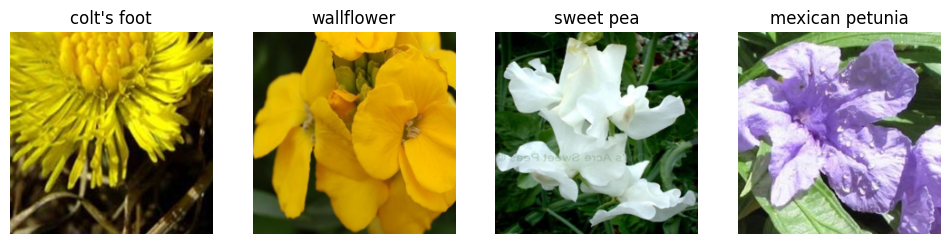

In [13]:
def imshow(inp, title = None):
    """ Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

inputs, classes = next(iter(train_loader))

plt.figure(figsize=(12, 6))
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    imshow(inputs[i])
    label_idx = str(train_dataset.classes[classes[i]])
    flower_name = cat_to_name.get(label_idx, "Unknown")
    ax.set_title(flower_name)

plt.show()

## **STEP 3:** Define Model with CUDA, tailored for 102-class flower dataset

In [14]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet18(pretrained=True)

# Freeze pretrained weights so only the final layer is trained
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/run/media/xen0s/Volume/Projects/Image Classification/.venv/lib64/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/run/media/xen0s/Volume/Projects/Image Classification/.venv/lib64/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## **STEP 4:** Define Loss Function and Optimizer

* **Cross Entropy Loss:** standard for multiclass classification like flowers.
* **Adam Optimizer:** works without too much tuning; trains faster than vanilla SGD in many cases.
* **Scheduler:** prevents overshooting by lowering the learning rate later in training.

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

## we only want to optimize the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Loss function and optimizer defined.")

Loss function and optimizer defined.


## **STEP 5:** Training & Validation Loop

In [16]:
import time
import copy
import torch
from torch import amp
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt

# =====================
# TRAINING SETUP
# =====================
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Lists to track history
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

scaler = amp.GradScaler()
num_epochs = 10
since = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("=" * 30)

    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    running_corrects = 0
    train_bar = tqdm(train_loader, desc='Training', leave=False)

    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, -1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        train_bar.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

    # --- VALIDATION ---
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="Validation", leave=False)
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            val_bar.set_postfix(loss=loss.item())

    epoch_val_loss = running_loss / len(val_loader.dataset)
    epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

    print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}")
    print(f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    # Record metrics for plotting
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc.item())
    valid_accs.append(epoch_val_acc.item())

    # Save best model weights
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# Load best weights
model.load_state_dict(best_model_wts)
print(f"Best validation accuracy: {best_acc:.4f}")

/run/media/xen0s/Volume/Projects/Image Classification/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Epoch 1/10


Train Loss: 2.1035 Acc: 0.5566
Val Loss: 0.6348 Acc: 0.8521

Epoch 2/10


Train Loss: 0.8241 Acc: 0.7955
Val Loss: 0.3700 Acc: 0.9083

Epoch 3/10


Train Loss: 0.6199 Acc: 0.8396
Val Loss: 0.3445 Acc: 0.9059

Epoch 4/10


Train Loss: 0.5553 Acc: 0.8462
Val Loss: 0.3819 Acc: 0.8888

Epoch 5/10


Train Loss: 0.5234 Acc: 0.8597
Val Loss: 0.3201 Acc: 0.9132

Epoch 6/10


Train Loss: 0.4876 Acc: 0.8643
Val Loss: 0.3258 Acc: 0.9108

Epoch 7/10


Train Loss: 0.4653 Acc: 0.8698
Val Loss: 0.3165 Acc: 0.9120

Epoch 8/10


Train Loss: 0.4626 Acc: 0.8700
Val Loss: 0.3829 Acc: 0.9034

Epoch 9/10


Train Loss: 0.4401 Acc: 0.8741
Val Loss: 0.2824 Acc: 0.9254

Epoch 10/10


Train Loss: 0.4293 Acc: 0.8840
Val Loss: 0.2837 Acc: 0.9205
Best validation accuracy: 0.9254


## **STEP 6:** Save the model and vizualize training progress
1. Save the **best model weight** for later interface.
2. Save the **class-to-name mapping** (`cat_to_name.json`) so the model can return flower names instead of numbers.
3. Plot the training and validation accuracy/loss curves to inspect overfitting or underfitting.

Model saved to best_flower_model.pth
Class mapping saved to class_mapping.json


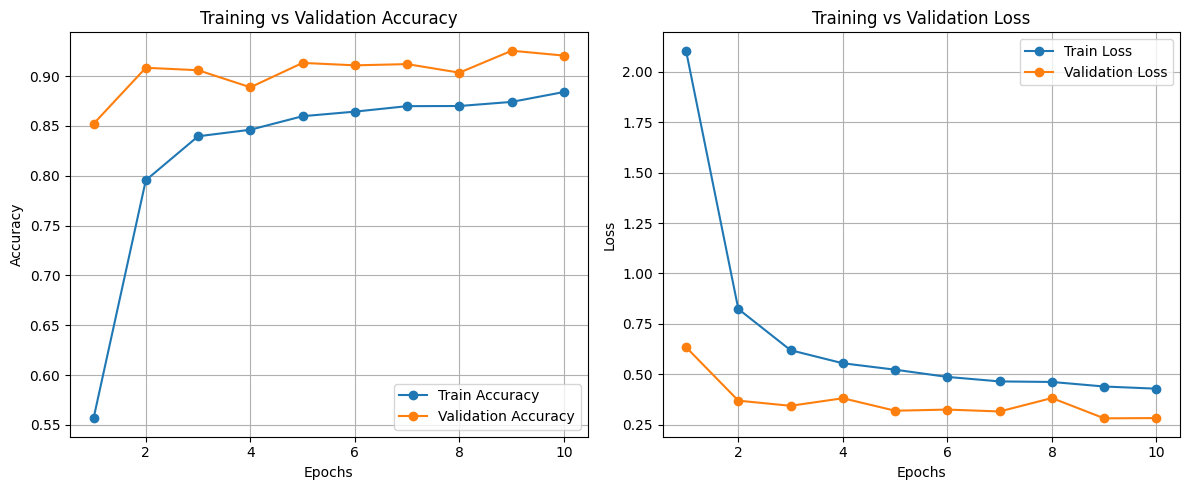

In [17]:
# =====================
# SAVE MODEL & MAPPING
# =====================
model_save_path = "best_flower_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

with open(json_file_path, "r") as f:
    cat_to_name = json.load(f)

mapping_save_path = "class_mapping.json"
with open(mapping_save_path, "w") as f:
    json.dump(cat_to_name, f)
print(f"Class mapping saved to {mapping_save_path}")

# =====================
# PLOTTING
# =====================
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accs, label="Train Accuracy", marker='o')
plt.plot(epochs_range, valid_accs, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
plt.plot(epochs_range, valid_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## **STEP 7:** Model Evaluation and Interference.
1. Load the saved model and mapping
2. Run predictions on new images (either from validation on your own local files)
3. Visualize Predicitions along the ground truth

In [18]:
model.load_state_dict(torch.load("./best_flower_model.pth", map_location=device))
model.to(device=device)
model.eval()

with open("class_mapping.json", "r") as f:
    cat_to_name = json.load(f)

In [19]:
inference_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

In [20]:
from PIL import Image

import os
import json
import torch
test_dir = os.path.join(data_dir, "test")
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.lower().endswith((".jpg", ".png"))]

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

with open("idx_to_class.json", "w") as f:
    json.dump(idx_to_class, f)

def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = inference_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred_idx = torch.max(outputs, 1)
        pred_idx = pred_idx.item()

    # Convert model output index to actual class label
    class_label = idx_to_class[pred_idx]
    
    # Get human-readable name
    flower_name = cat_to_name.get(class_label, "Unknown")
    
    return image, flower_name

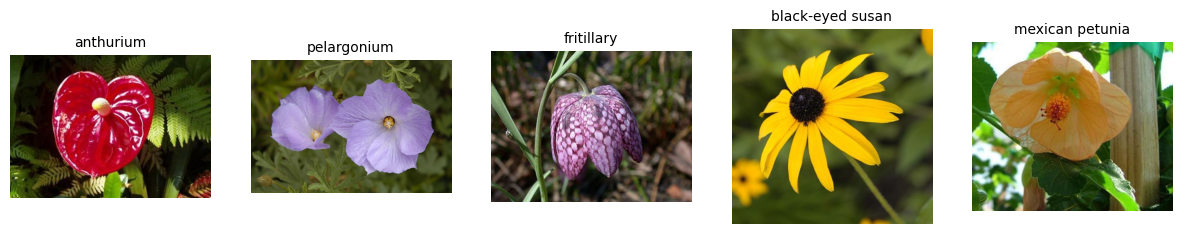

In [21]:
import random

sample_images = random.sample(test_images, 5)
plt.figure(figsize=(15, 6))
for i, img_path in enumerate(sample_images):
    img, label = predict_image(img_path)
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(img)
    plt.title(label, fontsize=10)
    plt.axis("off")
plt.show()

In [22]:
import os
import shutil

# Flatten test_dir back into a single folder
flat_test_dir = os.path.join(data_dir, "test_flat")
os.makedirs(flat_test_dir, exist_ok=True)

for root, dirs, files in os.walk(test_dir):
    for file in files:
        src = os.path.join(root, file)
        dst = os.path.join(flat_test_dir, file)

        if not os.path.exists(dst):  # avoid overwriting
            shutil.move(src, dst)

print("✅ Test set flattened into:", flat_test_dir)


✅ Test set flattened into: ../../data/flower_data/test_flat
